# Week 9
> Week 9 exercises.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter, exercise]
- image: images/chart-preview.png

In [761]:
#hide
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [762]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')


In [763]:
import torch
torch.cuda.empty_cache()

In [764]:
import base64
from io import BytesIO
from PIL import Image

import pandas as pd
import numpy as np
import requests
import bs4 as bs

import regex as re

import seaborn as sns
sns.set_style()

In [765]:
path = untar_data(URLs.MNIST_SAMPLE)

In [766]:
Path.BASE_PATH = path

In [767]:
path.ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

In [768]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [769]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

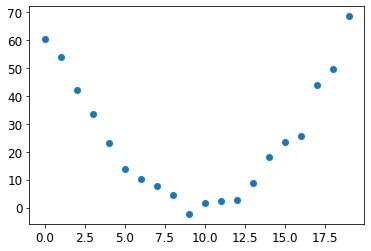

In [770]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [771]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [772]:
def mse(preds, targets): return ((preds-targets)**2).mean().sqrt()

### Step 1: Initialize the parameteres

In [773]:
params = torch.randn(3).requires_grad_()

In [774]:
#hide
orig_params = params.clone()

### Step 2: Calculate the predictions

In [775]:
preds = f(time, params)

In [776]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

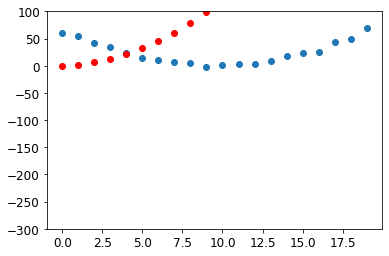

In [777]:
show_preds(preds)

### Step 3: Calculate the loss

In [778]:
loss = mse(preds, speed)
loss

tensor(178.9218, grad_fn=<SqrtBackward>)

### Step 4: Calculate the gradients

In [779]:
loss.backward()
params.grad

tensor([166.2099,  10.6992,   0.6881])

In [780]:
params.grad * 1e-5

tensor([1.6621e-03, 1.0699e-04, 6.8806e-06])

In [781]:
params

tensor([1.1480, 0.5953, 0.2770], requires_grad=True)

### Step 5: Step the weights
Update the parameters:

In [782]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

See if it has improved:

In [783]:
preds = f(time,params)
mse(preds, speed)

tensor(178.6444, grad_fn=<SqrtBackward>)

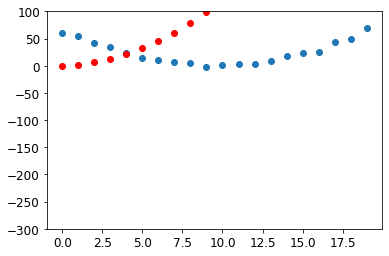

In [784]:
show_preds(preds)

In [785]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

### Step 6: Repeat the process

In [786]:
for i in range(10): apply_step(params)

178.6444091796875
178.3670196533203
178.0896453857422
177.81228637695312
177.53494262695312
177.25762939453125
176.98031616210938
176.7030029296875
176.42576599121094
176.14849853515625


In [787]:
#hide
params = orig_params.detach().requires_grad_()

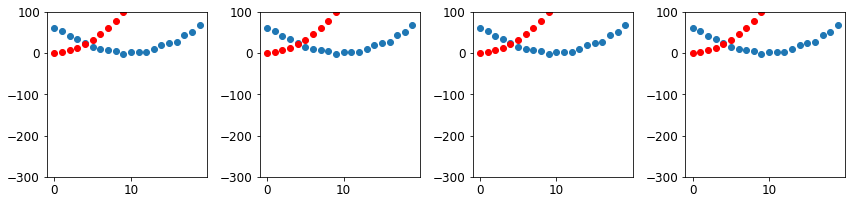

In [788]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

### Step 7: Stop

## The MNIST Loss Function

In [789]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [790]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [791]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [792]:
valid_3_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [793]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [794]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [795]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [796]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [797]:
weights = init_params((28*28,1))

In [798]:
bias = init_params(1)

In [799]:
(train_x[0]*weights.T).sum() + bias

tensor([2.8989], grad_fn=<AddBackward0>)

In [800]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ 2.8989],
        [ 4.2560],
        [-0.2983],
        ...,
        [ 7.7305],
        [13.6528],
        [ 5.9436]], grad_fn=<AddBackward0>)

In [801]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [False],
        ...,
        [False],
        [False],
        [False]])

In [802]:
corrects.float().mean().item()

0.4309454560279846

In [803]:
weights[0] *= 1.0001

In [804]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.4309454560279846

In [805]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [806]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [807]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [808]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [809]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

In [810]:
def sigmoid(x): return 1/(1+torch.exp(-x))

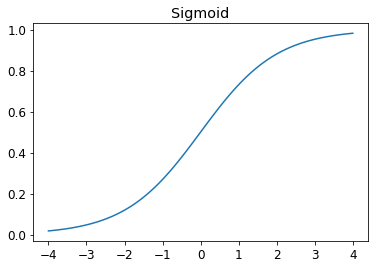

In [811]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [812]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [813]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 7, 14,  3,  0,  6]),
 tensor([ 1, 12, 10,  5,  8]),
 tensor([13,  9,  4,  2, 11])]

In [814]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [815]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([ 1, 10,  7,  9, 24, 17]), ('b', 'k', 'h', 'j', 'y', 'r')),
 (tensor([ 6, 12, 16, 15, 19,  2]), ('g', 'm', 'q', 'p', 't', 'c')),
 (tensor([ 0, 20,  5, 23,  3, 25]), ('a', 'u', 'f', 'x', 'd', 'z')),
 (tensor([ 4,  8, 21, 11, 13, 14]), ('e', 'i', 'v', 'l', 'n', 'o')),
 (tensor([18, 22]), ('s', 'w'))]

### Putting It All Together

Re-initialize parameters:

In [816]:
weights = init_params((28*28,1))
bias = init_params(1)

`DataLoader` created from a `Dataset`:

In [817]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

Same for the validation set:

In [818]:
valid_dl = DataLoader(valid_dset, batch_size=256)

Mini-batch of size 4 for testing:

In [819]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [820]:
preds = linear1(batch)
preds

tensor([[8.0212],
        [9.3134],
        [2.0936],
        [7.6557]], grad_fn=<AddBackward0>)

In [821]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.0277, grad_fn=<MeanBackward0>)

Calculate the gradients:

In [822]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad


(torch.Size([784, 1]), tensor(-0.0035), tensor([-0.0246]))

Everything in a function:

In [823]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

Test the function:

In [824]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0071), tensor([-0.0493]))

If we call it twice the gradients change:

In [825]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0106), tensor([-0.0739]))

Reason being that the `loss.backward` *adds* the gradients of `loss` to any currently stored gradients.
So we need to set the current gradients to 0 first:

In [826]:
weights.grad.zero_()
bias.grad.zero_();

> note: Inplace Operations: Methods in PyTorch whose names end in an underscore modify their objects _in place_. For instance, `bias.zero_()` sets all elements of the tensor `bias` to 0.

In [827]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [828]:
(preds>0.0).float() == train_y[:4]

tensor([[True],
        [True],
        [True],
        [True]])

Function to calculate validation accuracy:

In [829]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

Check it works:

In [830]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

Put the batches together:

In [831]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [832]:
validate_epoch(linear1)

0.3944

##### Starting point done.
Train for one epoch to see if accuray improves:

In [833]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.4917

Then a few more:

In [834]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.4942 0.4986 0.7137 0.7324 0.8769 0.9233 0.9433 0.9511 0.9536 0.9594 0.9628 0.9623 0.9662 0.9682 0.9687 0.9697 0.9711 0.9726 0.9726 0.9731 

In [852]:
class MyLearner():

    def __init__(self, dls : DataLoaders, model, loss_func, opt_func, metrics, lr=1e-3):
        self.dls = dls
        self.model = model
        self.loss_func = loss_func
        self.opt_func = opt_func
        self.metrics = metrics
        self.lr = lr
        self.opt = self.opt_func([p for p in self.model.parameters() if p.requires_grad], lr=self.lr)

    def fit(self, n_epoch):
        for i in range(n_epoch):
            self.train_epoch()
            print(f"t_loss: {round(float(self.loss), 4)} acc: {self.validate_epoch()}", end='\n')

    def train_epoch(self):
        for xb,yb in self.dls.train:
            self.calc_grad(xb, yb)
            self.opt.step()
            self.opt.zero_grad()

    def calc_grad(self, xb, yb):
        self.preds = self.model(xb)
        self.loss_grad = self.loss_func(self.preds, yb)
        self.loss = self.loss_grad.clone()
        self.loss_grad.backward()


    def validate_epoch(self):
        accs = [self.metrics(self.model(xb), yb) for xb,yb in self.dls.valid]
        return round(torch.stack(accs).mean().item(), 4)

In [860]:
my_net = nn.Sequential(
    nn.Linear(28*28,128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,1),
)

In [856]:
dls = DataLoaders(dl, valid_dl)

In [861]:
my_learner = MyLearner(dls, my_net, loss_func=mnist_loss, opt_func=SGD, metrics=batch_accuracy)

In [862]:
my_learner.fit(40)

t_loss: 0.4746 acc: 0.5068
t_loss: 0.474 acc: 0.5068
t_loss: 0.4733 acc: 0.5068
t_loss: 0.4726 acc: 0.5073
t_loss: 0.4719 acc: 0.5078
t_loss: 0.4711 acc: 0.5093
t_loss: 0.4704 acc: 0.5151
t_loss: 0.4696 acc: 0.5186
t_loss: 0.4689 acc: 0.5249
t_loss: 0.4681 acc: 0.5361
t_loss: 0.4673 acc: 0.5542
t_loss: 0.4664 acc: 0.5737
t_loss: 0.4656 acc: 0.5923
t_loss: 0.4647 acc: 0.6133
t_loss: 0.4638 acc: 0.6353
t_loss: 0.4629 acc: 0.6567
t_loss: 0.462 acc: 0.6816
t_loss: 0.461 acc: 0.7119
t_loss: 0.4601 acc: 0.7373
t_loss: 0.4591 acc: 0.7588
t_loss: 0.4581 acc: 0.7725
t_loss: 0.457 acc: 0.7964
t_loss: 0.456 acc: 0.811
t_loss: 0.4549 acc: 0.8281
t_loss: 0.4538 acc: 0.8413
t_loss: 0.4526 acc: 0.8564
t_loss: 0.4515 acc: 0.8691
t_loss: 0.4503 acc: 0.875
t_loss: 0.449 acc: 0.8813
t_loss: 0.4477 acc: 0.8867
t_loss: 0.4464 acc: 0.8984
t_loss: 0.445 acc: 0.9082
t_loss: 0.4436 acc: 0.9155
t_loss: 0.4421 acc: 0.9223
t_loss: 0.4406 acc: 0.9267
t_loss: 0.439 acc: 0.9287
t_loss: 0.4374 acc: 0.9316
t_loss: 0.4

In [ ]:
plt.plot(L(my_learner.recorder.values).itemgot(2));

### Creating an Optimizer

In [ ]:
linear_model = nn.Linear(28*28,1)

In [ ]:
w,b = linear_model.parameters()
w.shape,b.shape


























